
Rastrigin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=b7d74699f4e1a7a43d1e7f6c9ae05580d3883782e23740e06bee43b9eebb03ff
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dERM_GP'
util_grad_approx = 'ExpectedRegret'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
        
def objfunc_der(x1_training, x2_training):
        return  operator * (2 * x1_training + 20 * np.pi * np.sin(2 * np.pi * x1_training)
                                    + 2 * x2_training + 20 * np.pi * np.sin(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedRegret': self.ExpectedRegret,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def ExpectedRegret(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (mean - y_global_orig) * norm.cdf(z) + std * norm.pdf(z)[0]


    def dERM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1651583748.4471738

In [13]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84969467  2.25612281]	 -20.33436270766351	 -19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 -33.07414982069084	 -19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 -53.347974723929894	 -19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 -39.218472310354045	 -19.908403246996286	    
init	 [-1.05710106  0.39748336]	 -19.908403246996286	 -19.908403246996286	    
1  	 [ 4.04077223 -4.24914728]	 -44.655863836006326	 -19.908403246996286	 -0.7978846603251022
2  	 [4.64028151 5.12      ]	 -66.81752730899376	 -19.908403246996286	 -0.7978846383751512
3  	 [-5.12  5.12]	 -57.849427451571785	 -19.908403246996286	 -0.7978761219559242
4  	 [5.12       0.33809582]	 -44.29589120518327	 -19.908403246996286	 -0.7975553606158541
5  	 [ 0.22553122 -5.12      ]	 -37.4442083812247	 -19.908403246996286	 -0.787408703109066
6  	 [0.75630507 5.12      ]	 -39.100655645934765	 -19.908403246996286	 -0.7

In [14]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.6554122  -4.85451539]	 -43.490296251903594	 -18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 -35.91861667536101	 -18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 -20.479562046739524	 -18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 -18.964539418712707	 -18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 -28.041315668371354	 -18.964539418712707	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -0.7978840542504245
2  	 [4.77484577 5.12      ]	 -60.169093311219	 -18.964539418712707	 -0.7978846604856327
3  	 [-0.33018786  5.12      ]	 -43.86161461373481	 -18.964539418712707	 -0.7977884701018253
4  	 [5.12       0.08038296]	 -30.179725711112503	 -18.964539418712707	 -0.7976643058859941
5  	 [-5.12  5.12]	 -57.849427451571785	 -18.964539418712707	 -0.7975066491457234
6  	 [-5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -0.7960280226230926
7  	

In [15]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -10.607662635789808	 -0.7978846605384285
2  	 [-4.61904204  5.12      ]	 -67.59102009462822	 -10.607662635789808	 -0.7978830439313692
3  	 [ 5.12       -0.40159891]	 -47.234806525771404	 -10.607662635789808	 -0.7974458540787913
4  	 [ 0.29071736 -5.12      ]	 -41.53976060750644	 -10.607662635789808	 -0.7976140522106314
5  	 [ 1.34927722 -1.51093783]	 -39.92092770530185	 -10.607662635789808	 -0.7760872529847889
6  	 [-0.80321914  5.12      ]	 -36.28798476592165	 -10.607662635789808	 -0

In [16]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.78238555 0.48365823]	 -51.03163809010808	 -14.323038259018315	    
init	 [4.84028785 2.19971578]	 -39.78645699016559	 -14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 -14.323038259018315	 -14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 -52.80627247106233	 -14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 -41.61497868486559	 -14.323038259018315	    
1  	 [-0.75213717  4.73292922]	 -43.90258428635684	 -14.323038259018315	 -0.7978836093715236
2  	 [-5.12 -5.12]	 -57.849427451571785	 -14.323038259018315	 -0.7978666512334759
3  	 [-5.12        3.36771471]	 -57.006313118348025	 -14.323038259018315	 -0.7974679969535201
4  	 [-0.95956445 -5.12      ]	 -30.166488099443967	 -14.323038259018315	 -0.7916354725420243
5	 [0.89090871 1.10665818]	 -6.439744068363192	 -6.439744068363192	 -0.7803023961795099
6  	 [2.95832755 5.12      ]	 -38.01725142421135	 -6.439744068363192	 -0.7671499

In [17]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.84678993  3.79629882]	 -33.93442008827236	 -7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 -39.673876075575784	 -7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 -7.8108627039749745	 -7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 -25.38160395721669	 -7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 -22.589982116319675	 -7.8108627039749745	    
1  	 [ 5.12       -4.82910414]	 -57.47682591577337	 -7.8108627039749745	 -0.7978834393457521
2  	 [5.12 5.12]	 -57.849427451571785	 -7.8108627039749745	 -0.7978827837513032
3  	 [-5.12       -0.04624623]	 -29.346055646927017	 -7.8108627039749745	 -0.7971839241642429
4  	 [1.00367618 5.12      ]	 -29.934747080138813	 -7.8108627039749745	 -0.7914342615896365
5  	 [-5.12 -5.12]	 -57.849427451571785	 -7.8108627039749745	 -0.7891128643701013
6  	 [ 1.1069579 -5.12     ]	 -32.32451433069359	 -7.8108627039749745	 -0.788015772411

In [18]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [-3.50682913 -4.82182882]	 -61.17719800274786	 -17.28954482757088	 -0.7978833020644204
2  	 [5.12 5.12]	 -57.849427451571785	 -17.28954482757088	 -0.7978846602458711
3  	 [-5.12  5.12]	 -57.849427451571785	 -17.28954482757088	 -0.7974615534130703
4  	 [0.39543609 5.12      ]	 -46.99939788436357	 -17.28954482757088	 -0.7972182318650025
5  	 [2.84230651 1.91250873]	 -17.72964492594408	 -17.28954482757088	 -0.7784532132199081
6  	 [-5.12       -1.80313793]	 -38.89895054798167	 -17.28954482757088	 -0.7099765784093206
7  	 [

In [19]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.33860312  2.86636843]	 -45.646133072936244	 -22.52235437888213	    
init	 [-0.63068947  2.28828342]	 -34.83012662845338	 -22.52235437888213	    
init	 [4.8946126  0.39419771]	 -44.09657005662876	 -22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 -36.613209822404315	 -22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 -22.52235437888213	 -22.52235437888213	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -0.7978710524655791
2  	 [ 5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -0.7978669643409964
3  	 [3.59148274 5.12      ]	 -60.216456152688124	 -22.52235437888213	 -0.797796838988837
4  	 [-4.02558214 -1.33646422]	 -33.289738493146906	 -22.52235437888213	 -0.7978846605384292
5	 [ 1.40596242 -0.96124905]	 -21.500323674296737	 -21.500323674296737	 -0.7700992230642527
6  	 [-1.80774685  5.12      ]	 -38.64340927661605	 -21.500323674296737	 -0.687968010611

In [20]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.82391708 4.79785639]	 -50.20079446939181	 -13.871821018360485	    
init	 [3.78055209 0.31596228]	 -36.5114251593508	 -13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 -43.34985765011677	 -13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 -13.871821018360485	 -13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 -17.190590355445654	 -13.871821018360485	    
1  	 [-3.08049418  4.13284171]	 -31.107529727094295	 -13.871821018360485	 -0.7978831977255296
2  	 [ 5.12 -5.12]	 -57.849427451571785	 -13.871821018360485	 -0.7978832347822832
3  	 [-5.12       -0.39982603]	 -47.168314618373735	 -13.871821018360485	 -0.7977020618859711
4  	 [ 1.1839825  -4.40957154]	 -45.24488893987716	 -13.871821018360485	 -0.7872466516284291
5  	 [0.42088128 3.28854359]	 -42.17943004471983	 -13.871821018360485	 -0.7660031668203726
6  	 [-2.3877296   1.21881035]	 -32.85298825828709	 -13.871821018360485	 -0.5

In [21]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.01376866  0.01919582]	 -25.248289026162446	 -24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 -24.454800313488693	 -24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 -39.46509426509438	 -24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 -31.06766397812992	 -24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 -49.922543556206975	 -24.454800313488693	    
1  	 [3.69491889 4.82146316]	 -55.95031066333101	 -24.454800313488693	 -0.7978846605384289
2  	 [-2.19884748  5.08680517]	 -39.002426583702	 -24.454800313488693	 -0.7978840115058652
3  	 [ 5.10452216 -0.68397541]	 -42.63453098314871	 -24.454800313488693	 -0.7978832010020596
4  	 [ 4.49553512 -5.12      ]	 -69.13061496361522	 -24.454800313488693	 -0.797348595830772
5  	 [0.62467764 1.48438927]	 -39.63094404175255	 -24.454800313488693	 -0.7964733084073282
6  	 [-5.12        3.40866694]	 -58.94182754169992	 -24.45480031348

In [22]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.77832339 -4.90750004]	 -41.674330194390116	 -13.839458310244165	    
init	 [1.36855793 2.54775176]	 -44.69639719065837	 -13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 -13.839458310244165	 -13.839458310244165	    
init	 [-3.09183626  2.66783449]	 -33.23221510904937	 -13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 -54.73014366983691	 -13.839458310244165	    
1  	 [ 5.12       -0.56860392]	 -48.33329462653664	 -13.839458310244165	 -0.797752889743107
2  	 [5.12 5.12]	 -57.849427451571785	 -13.839458310244165	 -0.7975242619791582
3  	 [-5.12       -0.60617906]	 -47.14809482049852	 -13.839458310244165	 -0.7883924762093706
4  	 [-5.12  5.12]	 -57.849427451571785	 -13.839458310244165	 -0.7464576628544131
5  	 [-0.8379355  5.12     ]	 -34.378552324866575	 -13.839458310244165	 -0.7302607178501846
6	 [-1.23133198 -0.10555143]	 -12.47679380872663	 -12.47679380872663	 -0.711454816254562


In [23]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.27403839 -4.92057353]	 -47.655641290890955	 -10.679755252484755	    
init	 [-0.37664229  2.30332343]	 -35.87889240695259	 -10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 -10.679755252484755	 -10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 -28.05462905574235	 -10.679755252484755	    
init	 [4.52410012 3.59214172]	 -71.62694632141611	 -10.679755252484755	    
1  	 [ 3.73200513 -5.12      ]	 -53.98081952906584	 -10.679755252484755	 -0.7978846599405377
2  	 [-5.12  5.12]	 -57.849427451571785	 -10.679755252484755	 -0.7978752424817925
3  	 [ 5.12       -0.89340784]	 -31.883049733418897	 -10.679755252484755	 -0.796563976311785
4  	 [ 0.31356246 -3.36750001]	 -42.05692693601467	 -10.679755252484755	 -0.7765713039686895
5  	 [1.20983398 5.12      ]	 -37.89141064809076	 -10.679755252484755	 -0.7289801100515292
6  	 [2.15080916 0.11826921]	 -11.439624560238133	 -10.679755252484755	 -0.6

In [24]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.54137249  2.45810889]	 -57.903242869085595	 -40.51116653209555	    
init	 [-2.42365424  0.34549139]	 -40.51116653209555	 -40.51116653209555	    
init	 [-4.97075238  4.28796936]	 -55.62655915398208	 -40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 -49.962803461970296	 -40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 -62.183891474990624	 -40.51116653209555	    
1  	 [4.12828398 5.12      ]	 -49.04377260896486	 -40.51116653209555	 -0.79788466053831
2  	 [-5.12 -5.12]	 -57.849427451571785	 -40.51116653209555	 -0.7978845767886578
3  	 [2.40876004 0.58851143]	 -43.04277302743077	 -40.51116653209555	 -0.7976097606122838
4	 [-0.48693952 -4.12692577]	 -40.24998226952083	 -40.24998226952083	 -0.7974026457300695
5  	 [-5.12      -1.5444533]	 -50.922513303092174	 -40.24998226952083	 -0.7311796290773789
6	 [-0.17351928  5.12      ]	 -34.33221949920649	 -34.33221949920649	 -0.795225459524138
7

In [25]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.84367268 -2.68757791]	 -33.58019830007169	 -17.435826639425656	    
init	 [3.32061217 4.76927179]	 -56.857057997503354	 -17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 -48.211919361679726	 -17.435826639425656	    
init	 [1.11659482 2.82139151]	 -17.435826639425656	 -17.435826639425656	    
init	 [1.45012065 2.27346667]	 -38.25352329493884	 -17.435826639425656	    
1  	 [-4.10876704 -2.60547476]	 -43.79941556238635	 -17.435826639425656	 -0.7978846602612047
2  	 [-4.210207    3.16126079]	 -39.95389880951034	 -17.435826639425656	 -0.7978830047666959
3  	 [-0.62130064 -5.12      ]	 -46.544229285892115	 -17.435826639425656	 -0.7957585441811007
4  	 [-0.72633031 -0.82502418]	 -18.148696375637392	 -17.435826639425656	 -0.7797129321409187
5  	 [-1.0340358  5.12     ]	 -30.221739620703865	 -17.435826639425656	 -0.7768368870552249
6  	 [-5.12        0.27694188]	 -40.68614565908879	 -17.435826639

In [26]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.14277984 2.79721013]	 -18.683085263052178	 -10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 -47.36348784446708	 -10.423838604848608	    
init	 [-1.94830412  4.68586229]	 -40.19779334078636	 -10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 -10.423838604848608	 -10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 -30.353548735049138	 -10.423838604848608	    
1  	 [-4.70484912 -5.12      ]	 -63.85933234515868	 -10.423838604848608	 -0.7978833948748169
2  	 [5.12 5.12]	 -57.849427451571785	 -10.423838604848608	 -0.79788337333807
3  	 [-5.12        0.35849491]	 -45.354322655683745	 -10.423838604848608	 -0.7978743222543981
4  	 [ 5.12       -0.06395671]	 -29.725421589142265	 -10.423838604848608	 -0.7978398020030241
5  	 [-1.64697247  0.04263764]	 -19.101722950488842	 -10.423838604848608	 -0.7256847703456325
6  	 [-5.12  5.12]	 -57.849427451571785	 -10.423838604848608	 -0.739611226

In [27]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.57189322 -3.28810573]	 -54.938487770767075	 -7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 -60.750198753157726	 -7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 -31.984997246800887	 -7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 -7.990765314336182	 -7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 -41.754957769694336	 -7.990765314336182	    
1  	 [5.12       4.80077407]	 -58.83575650942072	 -7.990765314336182	 -0.7978846605384032
2  	 [-5.12      5.068432]	 -55.52393816380152	 -7.990765314336182	 -0.7978828978712603
3  	 [0.00795539 5.12      ]	 -28.9372670078654	 -7.990765314336182	 -0.7978229783957769
4  	 [2.2529431  1.11070694]	 -18.817589379945236	 -7.990765314336182	 -0.7968887790225914
5  	 [-0.33197567 -5.12      ]	 -43.96086453827371	 -7.990765314336182	 -0.7941093496415288
6  	 [5.12       0.08146084]	 -30.212870206517803	 -7.990765314336182	 -0.73945

In [28]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.83349935  0.23719262]	 -22.27210456874814	 -22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 -57.57021076017139	 -22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 -33.89145899403749	 -22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 -35.85029586225333	 -22.27210456874814	    
init	 [-4.39987336  4.51595121]	 -77.78800881964571	 -22.27210456874814	    
1  	 [2.142749   4.83374619]	 -36.69381850109535	 -22.27210456874814	 -0.7978846505667335
2  	 [5.12       0.59289917]	 -47.620520561702925	 -22.27210456874814	 -0.7978571246419787
3  	 [-5.12 -5.12]	 -57.849427451571785	 -22.27210456874814	 -0.7972212615514614
4	 [1.00686592 0.83549834]	 -6.603799654593312	 -6.603799654593312	 -0.7898773079881505
5  	 [-0.94229223  3.24295445]	 -21.612310053023446	 -6.603799654593312	 -0.7318589319365801
6  	 [ 5.12 -5.12]	 -57.849427451571785	 -6.603799654593312	 -0.7858160750168369
7  	 [-5.

In [29]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.10263037  0.31320838]	 -20.395145364684023	 -20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 -53.03732051200137	 -20.395145364684023	    
init	 [2.93873111 1.60085526]	 -29.989224812583537	 -20.395145364684023	    
init	 [1.40821398 0.77417363]	 -29.451989415882437	 -20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 -55.89242173757483	 -20.395145364684023	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -20.395145364684023	 -0.7978846602483369
2  	 [-4.70696363  5.12      ]	 -63.751442331381455	 -20.395145364684023	 -0.7978830225066619
3  	 [0.05624567 5.12      ]	 -29.54586982234551	 -20.395145364684023	 -0.7972640139194559
4  	 [5.12 5.12]	 -57.849427451571785	 -20.395145364684023	 -0.7965821614550538
5  	 [ 1.0772637  -3.51432737]	 -34.62590777738393	 -20.395145364684023	 -0.7949937507262191
6  	 [ 5.12       -1.25380509]	 -40.73579907752291	 -20.395145364684023	 -0.7781201272706

In [30]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53983224 0.05584255]	 -22.67190580753611	 -22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 -38.990099416711985	 -22.67190580753611	    
init	 [3.60686662 2.56139557]	 -56.66448698782129	 -22.67190580753611	    
init	 [1.70088108 4.99604939]	 -40.894059318256296	 -22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 -54.6725749848372	 -22.67190580753611	    
1  	 [-5.00718904  2.9174042 ]	 -34.91005808676357	 -22.67190580753611	 -0.7978846602937384
2  	 [-5.12       -1.37222114]	 -47.75423927503102	 -22.67190580753611	 -0.7959247032744787
3  	 [-1.30205519  2.41793783]	 -39.45440344033703	 -22.67190580753611	 -0.779750150550896
4  	 [ 1.04804663 -5.12      ]	 -30.475340679800027	 -22.67190580753611	 -0.7424632784623878
5  	 [-1.46191314 -1.33679084]	 -38.82616668516041	 -22.67190580753611	 -0.7344233062685958
6  	 [-2.73822076  5.12      ]	 -47.16200281291928	 -22.67190580753611	 -0.656

In [31]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.12125592  2.6751971 ]	 -41.43485596167127	 -25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 -51.60126035043229	 -25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 -43.97430127029199	 -25.867003842388073	    
init	 [1.76104531 3.13952049]	 -25.867003842388073	 -25.867003842388073	    
init	 [4.9432772  1.38916592]	 -44.66580306903559	 -25.867003842388073	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -25.867003842388073	 -0.7978846532444869
2  	 [ 1.77619183 -1.68662994]	 -28.238598176994593	 -25.867003842388073	 -0.7963185566879285
3  	 [5.12 5.12]	 -57.849427451571785	 -25.867003842388073	 -0.7843002942134734
4  	 [-1.28669736  5.12      ]	 -42.86568982158356	 -25.867003842388073	 -0.7798914628615135
5  	 [-5.12       -0.97841389]	 -29.973843406152113	 -25.867003842388073	 -0.7794668826420584
6	 [-1.20054205  0.35649541]	 -24.713670269441536	 -24.713670269441536	 -0.7733933770682

In [32]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.9024594  4.07258857]	 -20.24255447774017	 -17.388691338534382	    
init	 [4.00927467 3.23417577]	 -35.55852254546393	 -17.388691338534382	    
init	 [-4.75249064  1.96359764]	 -36.54582989269194	 -17.388691338534382	    
init	 [-1.24230715  0.18955208]	 -17.388691338534382	 -17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 -33.22932870179905	 -17.388691338534382	    
1  	 [-5.12       -3.80666612]	 -49.92973216876375	 -17.388691338534382	 -0.7978833533453296
2  	 [ 5.12       -0.92644577]	 -30.832077746661763	 -17.388691338534382	 -0.7954811505020274
3  	 [ 5.12 -5.12]	 -57.849427451571785	 -17.388691338534382	 -0.7942093616709078
4  	 [-2.70369179  5.12      ]	 -49.103412182375216	 -17.388691338534382	 -0.7858816229492438
5  	 [-1.50461243 -5.12      ]	 -51.184373160495596	 -17.388691338534382	 -0.7814908328494902
6  	 [1.91189059 0.46615132]	 -25.14098277954536	 -17.388691338534382	 -0.

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1651583894.0227313

In [34]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84969467  2.25612281]	 -20.33436270766351	 -19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 -33.07414982069084	 -19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 -53.347974723929894	 -19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 -39.218472310354045	 -19.908403246996286	    
init	 [-1.05710106  0.39748336]	 -19.908403246996286	 -19.908403246996286	    
1  	 [ 4.04077223 -4.24914728]	 -44.655863836006326	 -19.908403246996286	 -0.7978845605763167
2  	 [3.95569971 5.12      ]	 -44.957164327661914	 -19.908403246996286	 -0.7978838089763671
3  	 [5.12       0.47931867]	 -49.07015084657466	 -19.908403246996286	 -0.7976772720298271
4  	 [-5.12        4.36680096]	 -64.69123843791516	 -19.908403246996286	 -0.7978285981450343
5  	 [ 0.20333181 -5.12      ]	 -36.07564817041229	 -19.908403246996286	 -0.7873734776942758
6  	 [ 1.75432371 -1.381871  ]	 -32.08524098920023	 -19.908403

In [35]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.6554122  -4.85451539]	 -43.490296251903594	 -18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 -35.91861667536101	 -18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 -20.479562046739524	 -18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 -18.964539418712707	 -18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 -28.041315668371354	 -18.964539418712707	    
1  	 [3.91207732 5.12      ]	 -45.71656758082061	 -18.964539418712707	 -0.7978845593456777
2  	 [ 4.84262143 -3.96515559]	 -43.91554200116249	 -18.964539418712707	 -0.797879475860544
3  	 [-0.81906025  5.12      ]	 -35.39128099258556	 -18.964539418712707	 -0.7975185508586904
4  	 [-5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -0.7960279226607768
5  	 [5.12       0.71181662]	 -41.80757997921023	 -18.964539418712707	 -0.7972836503410096
6  	 [-4.6297519   4.23289614]	 -65.13623895320521	 -18.964539418712707	 -0

In [36]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 1.80565001 -3.04761061]	 -19.5666404549755	 -10.607662635789808	 -0.7978724620298179
2  	 [-3.57871734  4.80548253]	 -61.28559802785699	 -10.607662635789808	 -0.7978231340014964
3  	 [ 5.12       -0.22832109]	 -37.61892634098497	 -10.607662635789808	 -0.7970260591446935
4  	 [-0.98127961 -5.12      ]	 -29.95672032642291	 -10.607662635789808	 -0.774028581846278
5  	 [-0.58862849 -1.88989711]	 -24.706324384530227	 -10.607662635789808	 -0.5350977103108296
6  	 [ 5.12       -4.57451492]	 -68.77476117581722	 -10.6076626357

In [37]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.78238555 0.48365823]	 -51.03163809010808	 -14.323038259018315	    
init	 [4.84028785 2.19971578]	 -39.78645699016559	 -14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 -14.323038259018315	 -14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 -52.80627247106233	 -14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 -41.61497868486559	 -14.323038259018315	    
1  	 [-1.01565322  4.77412453]	 -32.362152132578984	 -14.323038259018315	 -0.7978833220723834
2  	 [-5.12 -5.12]	 -57.849427451571785	 -14.323038259018315	 -0.7978665514846802
3  	 [-0.96892694 -5.12      ]	 -30.053517501182924	 -14.323038259018315	 -0.7916323173996104
4  	 [0.8312782 1.3534401]	 -23.686398382791577	 -14.323038259018315	 -0.7835469231850454
5  	 [-5.12        3.19466591]	 -45.72348149433688	 -14.323038259018315	 -0.7971648722769747
6  	 [4.10247948 5.12      ]	 -47.75743112638065	 -14.323038259018315	 -0.7089

In [38]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.84678993  3.79629882]	 -33.93442008827236	 -7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 -39.673876075575784	 -7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 -7.8108627039749745	 -7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 -25.38160395721669	 -7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 -22.589982116319675	 -7.8108627039749745	    
1  	 [ 4.32895605 -5.09732646]	 -61.29478907190488	 -7.8108627039749745	 -0.797883065867823
2  	 [5.12 5.12]	 -57.849427451571785	 -7.8108627039749745	 -0.7978826840026501
3  	 [-5.12      -0.2720871]	 -40.382068322008735	 -7.8108627039749745	 -0.7969871175751583
4  	 [1.01338591 5.12      ]	 -29.987013097899762	 -7.8108627039749745	 -0.7914297903850992
5  	 [-5.12 -5.12]	 -57.849427451571785	 -7.8108627039749745	 -0.7890531706227712
6  	 [ 0.62772912 -5.12      ]	 -46.26754003098997	 -7.8108627039749745	 -0.7595707671592

In [39]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -17.28954482757088	 -0.7978845412195068
2  	 [4.64255669 5.12      ]	 -66.72769251837904	 -17.28954482757088	 -0.7978845603347466
3  	 [0.02050218 5.12      ]	 -29.00799105330946	 -17.28954482757088	 -0.7965720490386261
4  	 [-0.92932825 -5.12      ]	 -30.758145614142002	 -17.28954482757088	 -0.793616018299442
5  	 [2.51815483 1.92164354]	 -31.156480488159588	 -17.28954482757088	 -0.7723336780628296
6  	 [-3.62819326  4.5323828 ]	 -70.42778022243338	 -17.28954482757088	 -0.77851935964

In [40]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.33860312  2.86636843]	 -45.646133072936244	 -22.52235437888213	    
init	 [-0.63068947  2.28828342]	 -34.83012662845338	 -22.52235437888213	    
init	 [4.8946126  0.39419771]	 -44.09657005662876	 -22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 -36.613209822404315	 -22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 -22.52235437888213	 -22.52235437888213	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -0.797870952716848
2  	 [3.74335335 5.12      ]	 -53.35490818566568	 -22.52235437888213	 -0.797793214328553
3  	 [ 4.5282828  -4.16265257]	 -62.45872989450317	 -22.52235437888213	 -0.7972335857430365
4  	 [-4.02558214 -1.33646422]	 -33.289738493146906	 -22.52235437888213	 -0.7978845607896438
5	 [ 1.30561205 -0.85934452]	 -19.524180402300825	 -19.524180402300825	 -0.7683568004415693
6  	 [0.93890964 4.55031943]	 -41.818975193307054	 -19.524180402300825	 -0.4486

In [41]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.82391708 4.79785639]	 -50.20079446939181	 -13.871821018360485	    
init	 [3.78055209 0.31596228]	 -36.5114251593508	 -13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 -43.34985765011677	 -13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 -13.871821018360485	 -13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 -17.190590355445654	 -13.871821018360485	    
1  	 [ 4.96380166 -4.82581639]	 -53.599814786253866	 -13.871821018360485	 -0.7978763317050179
2  	 [-5.03492225  2.95509263]	 -34.71822332027364	 -13.871821018360485	 -0.79788444716443
3  	 [-0.90141252  5.12      ]	 -31.59524103717134	 -13.871821018360485	 -0.7975520979446603
4  	 [ 1.08442296 -4.7906971 ]	 -32.971633322227845	 -13.871821018360485	 -0.7831298674625679
5  	 [-5.12       -1.43958901]	 -50.285357808233925	 -13.871821018360485	 -0.7960827942130371
6	 [-1.95001889  1.93097606]	 -8.946098136270532	 -8.946098136270

In [42]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.01376866  0.01919582]	 -25.248289026162446	 -24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 -24.454800313488693	 -24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 -39.46509426509438	 -24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 -31.06766397812992	 -24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 -49.922543556206975	 -24.454800313488693	    
1  	 [3.69491889 4.82146316]	 -55.95031066333101	 -24.454800313488693	 -0.7978845607896434
2  	 [ 5.12       -0.96381407]	 -30.111009209089183	 -24.454800313488693	 -0.7978840874700128
3  	 [-1.75726245  4.33524886]	 -46.530066187987714	 -24.454800313488693	 -0.7978778595724014
4	 [1.32149658 1.04456568]	 -17.56964296332381	 -17.56964296332381	 -0.7950745748371193
5  	 [ 2.60463618 -2.60486245]	 -49.39182228410674	 -17.56964296332381	 -0.6312987069386747
6  	 [-4.85459855  3.02292184]	 -36.69959614874654	 -17.5696429633

In [43]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.77832339 -4.90750004]	 -41.674330194390116	 -13.839458310244165	    
init	 [1.36855793 2.54775176]	 -44.69639719065837	 -13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 -13.839458310244165	 -13.839458310244165	    
init	 [-3.09183626  2.66783449]	 -33.23221510904937	 -13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 -54.73014366983691	 -13.839458310244165	    
1  	 [ 5.12       -0.53449745]	 -48.976408281386696	 -13.839458310244165	 -0.7977518726783505
2  	 [5.12 5.12]	 -57.849427451571785	 -13.839458310244165	 -0.7975239017722687
3  	 [-4.22754211 -0.73799094]	 -37.764185864993955	 -13.839458310244165	 -0.7623780099485141
4  	 [-0.63815671  5.12      ]	 -45.7950067420562	 -13.839458310244165	 -0.7253034063776163
5	 [ 1.90874419 -0.86604919]	 -9.330184102927806	 -9.330184102927806	 -0.6327770279327227
6  	 [-0.38458602 -5.12      ]	 -46.55650416140192	 -9.330184102927806	 -0.464

In [44]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.27403839 -4.92057353]	 -47.655641290890955	 -10.679755252484755	    
init	 [-0.37664229  2.30332343]	 -35.87889240695259	 -10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 -10.679755252484755	 -10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 -28.05462905574235	 -10.679755252484755	    
init	 [4.52410012 3.59214172]	 -71.62694632141611	 -10.679755252484755	    
1  	 [ 3.03550212 -4.46785095]	 -49.22040431745476	 -10.679755252484755	 -0.7978844046968582
2  	 [ 4.91302382 -0.64498034]	 -42.14029727890503	 -10.679755252484755	 -0.7943755131780043
3  	 [-1.19896852  5.12      ]	 -37.21049672982495	 -10.679755252484755	 -0.6832782830912949
4  	 [-0.14967075 -3.28094651]	 -26.82463242586251	 -10.679755252484755	 -0.7238346780005346
5  	 [-3.81010753  2.8468096 ]	 -33.219209813269664	 -10.679755252484755	 -0.7146534711654157
6  	 [2.1329683  0.84931955]	 -12.719354383500548	 -10.6797552

In [45]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.54137249  2.45810889]	 -57.903242869085595	 -40.51116653209555	    
init	 [-2.42365424  0.34549139]	 -40.51116653209555	 -40.51116653209555	    
init	 [-4.97075238  4.28796936]	 -55.62655915398208	 -40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 -49.962803461970296	 -40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 -62.183891474990624	 -40.51116653209555	    
1  	 [4.1801221 5.12     ]	 -52.14728433935211	 -40.51116653209555	 -0.7978845607895617
2  	 [-5.12 -5.12]	 -57.849427451571785	 -40.51116653209555	 -0.7978844770398728
3	 [2.21197022 0.79384263]	 -20.436184752851986	 -20.436184752851986	 -0.7975077084520088
4  	 [-0.46911892 -4.42609904]	 -58.56397644469437	 -20.436184752851986	 -0.7973698109850487
5  	 [5.12       0.02454424]	 -29.043993582333332	 -20.436184752851986	 -0.7330691659963839
6  	 [0.0875721 4.603205 ]	 -40.64330333892435	 -20.436184752851986	 -0.79290254964240

In [46]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.84367268 -2.68757791]	 -33.58019830007169	 -17.435826639425656	    
init	 [3.32061217 4.76927179]	 -56.857057997503354	 -17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 -48.211919361679726	 -17.435826639425656	    
init	 [1.11659482 2.82139151]	 -17.435826639425656	 -17.435826639425656	    
init	 [1.45012065 2.27346667]	 -38.25352329493884	 -17.435826639425656	    
1  	 [-4.10876704 -2.60547476]	 -43.79941556238635	 -17.435826639425656	 -0.7978845605124193
2  	 [-3.79946932  2.66821301]	 -43.412509428311274	 -17.435826639425656	 -0.7978634431683508
3  	 [-0.63511851 -5.12      ]	 -45.93562055650825	 -17.435826639425656	 -0.7957562276933146
4  	 [-0.69660879 -0.85998059]	 -18.143631230272202	 -17.435826639425656	 -0.7795174348314425
5  	 [-0.949167  5.12    ]	 -30.331370419796876	 -17.435826639425656	 -0.774281240734931
6  	 [-5.12 -5.12]	 -57.849427451571785	 -17.435826639425656	 -0.549

In [47]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.14277984 2.79721013]	 -18.683085263052178	 -10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 -47.36348784446708	 -10.423838604848608	    
init	 [-1.94830412  4.68586229]	 -40.19779334078636	 -10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 -10.423838604848608	 -10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 -30.353548735049138	 -10.423838604848608	    
1  	 [-4.82578806 -5.12      ]	 -57.62897652524626	 -10.423838604848608	 -0.7978838829425385
2  	 [5.12 5.12]	 -57.849427451571785	 -10.423838604848608	 -0.7978832735892898
3  	 [-4.94978572  0.25422714]	 -35.324181923041664	 -10.423838604848608	 -0.7978703328649795
4  	 [4.80749753 0.03051338]	 -29.761582978864574	 -10.423838604848608	 -0.7978229672823219
5  	 [-1.73927576  0.35706862]	 -30.057142830715556	 -10.423838604848608	 -0.7003485876984038
6  	 [-4.78091983  3.27931925]	 -53.51235760294291	 -10.423838604848608	 -

In [48]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.57189322 -3.28810573]	 -54.938487770767075	 -7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 -60.750198753157726	 -7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 -31.984997246800887	 -7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 -7.990765314336182	 -7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 -41.754957769694336	 -7.990765314336182	    
1  	 [5.12       3.74434704]	 -53.29995963390897	 -7.990765314336182	 -0.7978845607140601
2  	 [-3.93956611  5.12      ]	 -45.157200468068055	 -7.990765314336182	 -0.7978654987031752
3  	 [0.56205256 4.02888216]	 -35.96152088934213	 -7.990765314336182	 -0.7971148099050597
4  	 [-0.41695354 -5.12      ]	 -47.76781633366264	 -7.990765314336182	 -0.7940193101621129
5  	 [2.33291851 0.4796834 ]	 -40.5686499740102	 -7.990765314336182	 -0.787707465937368
6  	 [-5.12 -5.12]	 -57.849427451571785	 -7.990765314336182	 -0.649663143779

In [49]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.83349935  0.23719262]	 -22.27210456874814	 -22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 -57.57021076017139	 -22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 -33.89145899403749	 -22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 -35.85029586225333	 -22.27210456874814	    
init	 [-4.39987336  4.51595121]	 -77.78800881964571	 -22.27210456874814	    
1  	 [2.142749   4.83374619]	 -36.69381850109535	 -22.27210456874814	 -0.7978845508179482
2  	 [5.12       0.59422797]	 -47.57579460985678	 -22.27210456874814	 -0.7978570230040121
3  	 [-5.12 -5.12]	 -57.849427451571785	 -22.27210456874814	 -0.797221161805346
4	 [1.020987   0.80776409]	 -8.231448011305515	 -8.231448011305515	 -0.789862469751378
5  	 [-0.849334    3.07002449]	 -15.254856600817254	 -8.231448011305515	 -0.7239590164201554
6  	 [ 5.12       -3.14287922]	 -42.56859016945097	 -8.231448011305515	 -0.7419843314298696
7

In [50]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.10263037  0.31320838]	 -20.395145364684023	 -20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 -53.03732051200137	 -20.395145364684023	    
init	 [2.93873111 1.60085526]	 -29.989224812583537	 -20.395145364684023	    
init	 [1.40821398 0.77417363]	 -29.451989415882437	 -20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 -55.89242173757483	 -20.395145364684023	    
1  	 [ 4.96008736 -4.44720822]	 -64.14783177084814	 -20.395145364684023	 -0.7978845363013444
2  	 [-1.51861519  5.12      ]	 -51.16258242247814	 -20.395145364684023	 -0.7978357751909199
3  	 [5.12 5.12]	 -57.849427451571785	 -20.395145364684023	 -0.7966019890499955
4  	 [ 0.7748557  -3.17283017]	 -24.450909806974174	 -20.395145364684023	 -0.7917092326223857
5  	 [ 5.12       -0.76855727]	 -38.3520468084867	 -20.395145364684023	 -0.7410534194572955
6  	 [-5.12        2.95221798]	 -38.08759998703763	 -20.395145364684023	 -0.7

In [51]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53983224 0.05584255]	 -22.67190580753611	 -22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 -38.990099416711985	 -22.67190580753611	    
init	 [3.60686662 2.56139557]	 -56.66448698782129	 -22.67190580753611	    
init	 [1.70088108 4.99604939]	 -40.894059318256296	 -22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 -54.6725749848372	 -22.67190580753611	    
1  	 [-5.00718904  2.9174042 ]	 -34.91005808676357	 -22.67190580753611	 -0.797884560544953
2  	 [-2.51728859 -0.57163024]	 -45.60874492925909	 -22.67190580753611	 -0.7941877083433123
3  	 [-1.85577604  4.64440101]	 -45.005605029454756	 -22.67190580753611	 -0.7674391997802675
4  	 [ 1.00451354 -5.12      ]	 -29.93778218898035	 -22.67190580753611	 -0.7419953631117046
5  	 [-5.12       -2.72650916]	 -47.82918580534389	 -22.67190580753611	 -0.7160532761722209
6	 [-0.82577125  2.03320747]	 -10.449684907674122	 -10.449684907674122	 -0.485

In [52]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.12125592  2.6751971 ]	 -41.43485596167127	 -25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 -51.60126035043229	 -25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 -43.97430127029199	 -25.867003842388073	    
init	 [1.76104531 3.13952049]	 -25.867003842388073	 -25.867003842388073	    
init	 [4.9432772  1.38916592]	 -44.66580306903559	 -25.867003842388073	    
1  	 [ 4.34615016 -4.21152016]	 -59.91210672035738	 -25.867003842388073	 -0.7978830410330504
2	 [-0.62695024 -0.0324845 ]	 -17.585588423433606	 -17.585588423433606	 -0.7925140254652695
3  	 [5.12 5.12]	 -57.849427451571785	 -17.585588423433606	 -0.7843003982192052
4  	 [-1.28646676  5.12      ]	 -42.85098851783182	 -17.585588423433606	 -0.7798865497869671
5  	 [ 2.32181534 -1.16182355]	 -25.84020243023241	 -17.585588423433606	 -0.7365450497533451
6  	 [-5.12 -5.12]	 -57.849427451571785	 -17.585588423433606	 -0.633756066359564

In [53]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.9024594  4.07258857]	 -20.24255447774017	 -17.388691338534382	    
init	 [4.00927467 3.23417577]	 -35.55852254546393	 -17.388691338534382	    
init	 [-4.75249064  1.96359764]	 -36.54582989269194	 -17.388691338534382	    
init	 [-1.24230715  0.18955208]	 -17.388691338534382	 -17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 -33.22932870179905	 -17.388691338534382	    
1  	 [-3.7653899 -5.12     ]	 -52.1374053591766	 -17.388691338534382	 -0.797883832958918
2  	 [ 5.12       -0.91572029]	 -31.13288747603701	 -17.388691338534382	 -0.7954799077002277
3  	 [-2.32335582  4.695823  ]	 -55.23503374978317	 -17.388691338534382	 -0.764011187135419
4  	 [ 2.55240541 -0.47909495]	 -46.12094193929013	 -17.388691338534382	 -0.44348975874773333
5  	 [-3.1572227 -1.9643346]	 -18.571921289219965	 -17.388691338534382	 -0.6621569147519901
6  	 [ 4.68221667 -4.43412358]	 -74.87150444400916	 -17.388691338534382

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

249.6956992149353

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.9922089074363556, 2.1383468150232416)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(2.7020827331845028, 0.5700598073805034)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(3.2390286226608196, -0.15718053377076996)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.8624887983891776, 2.6349002808886928)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.824107834728892, 2.4674864186195844)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.8189801095208016, 2.5404680888199724)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.5470487663770065, 2.5226539737757663)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6964283864651377, 1.956251689894759)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.7482040141063537, 2.1248987615328234)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.523870423583159, 2.233254747025537)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.437083167252122, 2.5431248006097382)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(1.014942557483253, 1.6870103082832824)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.898598733097566, 2.7969422909867903)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.5025603976185735, 2.943131628584293)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.8937289290102335, 2.949886844872765)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.8876451886191041, 2.107961942263303)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.442265100137837, 2.3940457885936444)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.4258057052360242, 2.346571825580546)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.9653416892728535, 2.8670797270342203)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(3.0069571497238776, 2.3199819658634415)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

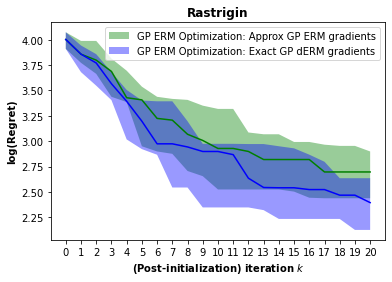

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(145.5754532814026, 249.6956992149353)

In [100]:
exact21_results, exact21_results[19:20].index[0]


(           0
 14  2.949887
 13  2.943132
 18  2.867080
 12  2.796942
 3   2.634900
 10  2.543125
 5   2.540468
 6   2.522654
 4   2.467486
 16  2.394046
 17  2.346572
 19  2.319982
 9   2.233255
 0   2.138347
 8   2.124899
 15  2.107962
 7   1.956252
 11  1.687010
 1   0.570060
 2  -0.157181, 2)

In [101]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'3'

In [102]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-10.607662635789808, -10.607662635789808, 2.361576630127625)

In [103]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -10.607662635789808	 -0.7978846605384285
2  	 [-4.61904204  5.12      ]	 -67.59102009462822	 -10.607662635789808	 -0.7978830439313692
3  	 [ 5.12       -0.40159891]	 -47.234806525771404	 -10.607662635789808	 -0.7974458540787913
4  	 [ 0.29071736 -5.12      ]	 -41.53976060750644	 -10.607662635789808	 -0.7976140522106314
5  	 [ 1.34927722 -1.51093783]	 -39.92092770530185	 -10.607662635789808	 -0.7760872529847889
6  	 [-0.80321914  5.12      ]	 -36.28798476592165	 -10.607662635789808	 -0

In [104]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[-1.26498569, -0.60441012],
        [ 2.11970448, -4.5156753 ],
        [-2.74938982,  2.04384954],
        [ 2.13861974,  0.73988516],
        [-2.44229021, -2.81105375],
        [ 0.34242049, -2.42007088],
        [ 2.4519435 ,  2.74120935],
        [ 2.24632233,  1.32231075],
        [ 4.02805526,  0.53879139],
        [-2.23179425, -2.68529055],
        [-4.0950846 ,  1.20579612],
        [ 2.71563985,  1.12907782],
        [-3.76415304,  2.05981458],
        [ 2.44896681, -1.3424912 ],
        [ 0.4846146 , -4.33049605],
        [ 1.00947   , -4.92907595],
        [-1.55501095,  3.164232  ],
        [ 1.31868059, -1.28112651],
        [ 4.23732641,  1.30211634],
        [ 4.39987335, -0.10964324]]),
 array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0.]),
 array([2.4519435 , 2.74120935]),
 array([2.4519435 , 2.74120935]))

In [105]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_maxAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_simpleRegret


(-0.8545497697986626, -0.009427232205568011, -0.15718053377076996)

In [106]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 1.80565001 -3.04761061]	 -19.5666404549755	 -10.607662635789808	 -0.7978724620298179
2  	 [-3.57871734  4.80548253]	 -61.28559802785699	 -10.607662635789808	 -0.7978231340014964
3  	 [ 5.12       -0.22832109]	 -37.61892634098497	 -10.607662635789808	 -0.7970260591446935
4  	 [-0.98127961 -5.12      ]	 -29.95672032642291	 -10.607662635789808	 -0.774028581846278
5  	 [-0.58862849 -1.88989711]	 -24.706324384530227	 -10.607662635789808	 -0.5350977103108296
6  	 [ 5.12       -4.57451492]	 -68.77476117581722	 -10.6076626357

In [107]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned, then multiply by -1 (NB!)


(array([[-1.26498569, -0.60441012],
        [ 2.11970448, -4.5156753 ],
        [-2.74938982,  2.04384954],
        [ 2.13861974,  0.73988516],
        [-2.44229021, -2.81105375],
        [ 0.34242049, -2.42007088],
        [ 2.45195069,  2.74119811],
        [ 2.24632233,  1.32231075],
        [ 4.02805526,  0.53879139],
        [-2.23179425, -2.68529055],
        [-4.0950846 ,  1.20579612],
        [ 2.71563985,  1.12907782],
        [-3.76415304,  2.05981458],
        [ 2.44896681, -1.3424912 ],
        [ 0.4846146 , -4.33049605],
        [ 1.00947   , -4.92907595],
        [-1.55501095,  3.164232  ],
        [ 1.10141669, -1.49839041],
        [ 4.23732641,  1.30211634],
        [ 4.39987335, -0.10964324]]),
 array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0.]),
 array([ 1.10141669, -1.49839041]),
 array([ 1.10141669, -1.49839041]))

In [108]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: is y-value greater?

True

In [109]:
eval_exactMinIQR_maxAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc # Exact gradients' model: is best AcqFunc greater?


True

In [110]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log lower?


True

In [111]:
eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_maxAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc


(-0.009427232205568011, -10.607662635789808, 0.0008887190825395339)

In [112]:
### MaxAcqFunc Comparison: Approximate Gradients

approx_1maxAcqFunc = approx_1.history[:-1][1::2]
approx_2maxAcqFunc = approx_2.history[:-1][1::2]
approx_3maxAcqFunc = approx_3.history[:-1][1::2]
approx_4maxAcqFunc = approx_4.history[:-1][1::2]
approx_5maxAcqFunc = approx_5.history[:-1][1::2]
approx_6maxAcqFunc = approx_6.history[:-1][1::2]
approx_7maxAcqFunc = approx_7.history[:-1][1::2]
approx_8maxAcqFunc = approx_8.history[:-1][1::2]
approx_9maxAcqFunc = approx_9.history[:-1][1::2]
approx_10maxAcqFunc = approx_10.history[:-1][1::2]
approx_11maxAcqFunc = approx_11.history[:-1][1::2]
approx_12maxAcqFunc = approx_12.history[:-1][1::2]
approx_13maxAcqFunc = approx_13.history[:-1][1::2]
approx_14maxAcqFunc = approx_14.history[:-1][1::2]
approx_15maxAcqFunc = approx_15.history[:-1][1::2]
approx_16maxAcqFunc = approx_16.history[:-1][1::2]
approx_17maxAcqFunc = approx_17.history[:-1][1::2]
approx_18maxAcqFunc = approx_18.history[:-1][1::2]
approx_19maxAcqFunc = approx_19.history[:-1][1::2]
approx_20maxAcqFunc = approx_20.history[:-1][1::2]


In [113]:
### MaxAcqFunc Comparison: Exact Gradients

exact_1maxAcqFunc = exact_1.history[:-1][1::2]
exact_2maxAcqFunc = exact_2.history[:-1][1::2]
exact_3maxAcqFunc = exact_3.history[:-1][1::2]
exact_4maxAcqFunc = exact_4.history[:-1][1::2]
exact_5maxAcqFunc = exact_5.history[:-1][1::2]
exact_6maxAcqFunc = exact_6.history[:-1][1::2]
exact_7maxAcqFunc = exact_7.history[:-1][1::2]
exact_8maxAcqFunc = exact_8.history[:-1][1::2]
exact_9maxAcqFunc = exact_9.history[:-1][1::2]
exact_10maxAcqFunc = exact_10.history[:-1][1::2]
exact_11maxAcqFunc = exact_11.history[:-1][1::2]
exact_12maxAcqFunc = exact_12.history[:-1][1::2]
exact_13maxAcqFunc = exact_13.history[:-1][1::2]
exact_14maxAcqFunc = exact_14.history[:-1][1::2]
exact_15maxAcqFunc = exact_15.history[:-1][1::2]
exact_16maxAcqFunc = exact_16.history[:-1][1::2]
exact_17maxAcqFunc = exact_17.history[:-1][1::2]
exact_18maxAcqFunc = exact_18.history[:-1][1::2]
exact_19maxAcqFunc = exact_19.history[:-1][1::2]
exact_20maxAcqFunc = exact_20.history[:-1][1::2]


In [114]:
### MaxAcqFunc Comparison: Experiment 1

maxAcqFuncApprox1 = np.mean(approx_1maxAcqFunc)
maxAcqFuncExact1 = np.mean(exact_1maxAcqFunc)
ratio1 = maxAcqFuncApprox1/maxAcqFuncExact1
approx_1.tau, exact_1.tau, maxAcqFuncApprox1, maxAcqFuncExact1, ratio1


(-19.908403246996286,
 -8.48539809445838,
 -0.3941248922281386,
 -0.3750614805683139,
 1.0508274313612231)

In [115]:
### MaxAcqFunc Comparison: Experiment 2

maxAcqFuncApprox2 = np.mean(approx_2maxAcqFunc)
maxAcqFuncExact2 = np.mean(exact_2maxAcqFunc)
ratio2 = maxAcqFuncApprox2/maxAcqFuncExact2
approx_2.tau, exact_2.tau, maxAcqFuncApprox2, maxAcqFuncExact2, ratio2


(-14.910754530812259,
 -1.7683728100166523,
 -0.4245179408503922,
 -0.36135519620747464,
 1.1747940677367545)

In [116]:
### MaxAcqFunc Comparison: Experiment 3

maxAcqFuncApprox3 = np.mean(approx_3maxAcqFunc)
maxAcqFuncExact3 = np.mean(exact_3maxAcqFunc)
ratio3 = maxAcqFuncApprox3/maxAcqFuncExact3
approx_3.tau, exact_3.tau, maxAcqFuncApprox3, maxAcqFuncExact3, ratio3


(-10.607662635789808,
 -0.8545497697986626,
 -5.486183504428942,
 -4.015180168490313,
 1.3663604805290015)

In [117]:
### MaxAcqFunc Comparison: Experiment 4

maxAcqFuncApprox4 = np.mean(approx_4maxAcqFunc)
maxAcqFuncExact4 = np.mean(exact_4maxAcqFunc)
ratio4 = maxAcqFuncApprox4/maxAcqFuncExact4
approx_4.tau, exact_4.tau, maxAcqFuncApprox4, maxAcqFuncExact4, ratio4


(-6.439744068363192,
 -13.941922117758516,
 -0.40544490706197633,
 -0.37383854992366244,
 1.084545473292596)

In [118]:
### MaxAcqFunc Comparison: Experiment 5

maxAcqFuncApprox5 = np.mean(approx_5maxAcqFunc)
maxAcqFuncExact5 = np.mean(exact_5maxAcqFunc)
ratio5 = maxAcqFuncApprox5/maxAcqFuncExact5
approx_5.tau, exact_5.tau, maxAcqFuncApprox5, maxAcqFuncExact5, ratio5


(-6.197263568655913,
 -7.8108627039749745,
 -0.4337058688448912,
 -0.4119147370188915,
 1.0529020446894095)

In [119]:
### MaxAcqFunc Comparison: Experiment 6

maxAcqFuncApprox6 = np.mean(approx_6maxAcqFunc)
maxAcqFuncExact6 = np.mean(exact_6maxAcqFunc)
ratio6 = maxAcqFuncApprox6/maxAcqFuncExact6
approx_6.tau, exact_6.tau, maxAcqFuncApprox6, maxAcqFuncExact6, ratio6


(-16.759748844346507,
 -12.685607572376263,
 -0.3618763486276556,
 -0.3368964437613988,
 1.0741471313480186)

In [120]:
### MaxAcqFunc Comparison: Experiment 7

maxAcqFuncApprox7 = np.mean(approx_7maxAcqFunc)
maxAcqFuncExact7 = np.mean(exact_7maxAcqFunc)
ratio7 = maxAcqFuncApprox7/maxAcqFuncExact7
approx_7.tau, exact_7.tau, maxAcqFuncApprox7, maxAcqFuncExact7, ratio7


(-12.769362746067559,
 -12.461625642827798,
 -0.35342834124815375,
 -0.29721688390235473,
 1.1891260570656756)

In [121]:
### MaxAcqFunc Comparison: Experiment 8

maxAcqFuncApprox8 = np.mean(approx_8maxAcqFunc)
maxAcqFuncExact8 = np.mean(exact_8maxAcqFunc)
ratio8 = maxAcqFuncApprox8/maxAcqFuncExact8
approx_8.tau, exact_8.tau, maxAcqFuncApprox8, maxAcqFuncExact8, ratio8


(-13.871821018360485,
 -7.072766395688511,
 -0.34376202101684716,
 -0.36065944760232377,
 0.9531485264068049)

In [122]:
### MaxAcqFunc Comparison: Experiment 9

maxAcqFuncApprox9 = np.mean(approx_9maxAcqFunc)
maxAcqFuncExact9 = np.mean(exact_9maxAcqFunc)
ratio9 = maxAcqFuncApprox9/maxAcqFuncExact9
approx_9.tau, exact_9.tau, maxAcqFuncApprox9, maxAcqFuncExact9, ratio9


(-15.61456315105384,
 -8.372049871726158,
 -0.388187883844548,
 -0.3799805199045735,
 1.0215994334184175)

In [123]:
### MaxAcqFunc Comparison: Experiment 10

maxAcqFuncApprox10 = np.mean(approx_10maxAcqFunc)
maxAcqFuncExact10 = np.mean(exact_10maxAcqFunc)
ratio10 = maxAcqFuncApprox10/maxAcqFuncExact10
approx_10.tau, exact_10.tau, maxAcqFuncApprox10, maxAcqFuncExact10, ratio10


(-12.47679380872663,
 -9.330184102927806,
 -0.36345387352348285,
 -0.31072772511382624,
 1.1696860117337193)

In [124]:
### MaxAcqFunc Comparison: Experiment 11

maxAcqFuncApprox11 = np.mean(approx_11maxAcqFunc)
maxAcqFuncExact11 = np.mean(exact_11maxAcqFunc)
ratio11 = maxAcqFuncApprox11/maxAcqFuncExact11
approx_11.tau, exact_11.tau, maxAcqFuncApprox11, maxAcqFuncExact11, ratio11


(-10.679755252484755,
 -10.679755252484755,
 -0.35326844950737785,
 -0.31121387218734436,
 1.1351307929317414)

In [125]:
### MaxAcqFunc Comparison: Experiment 12

maxAcqFuncApprox12 = np.mean(approx_12maxAcqFunc)
maxAcqFuncExact12 = np.mean(exact_12maxAcqFunc)
ratio12 = maxAcqFuncApprox12/maxAcqFuncExact12
approx_12.tau, exact_12.tau, maxAcqFuncApprox12, maxAcqFuncExact12, ratio12


(-2.759204897150486,
 -5.403302324793548,
 -0.3770929579154357,
 -0.361465309062125,
 1.0432341595763615)

In [126]:
### MaxAcqFunc Comparison: Experiment 13

maxAcqFuncApprox13 = np.mean(approx_13maxAcqFunc)
maxAcqFuncExact13 = np.mean(exact_13maxAcqFunc)
ratio13 = maxAcqFuncApprox13/maxAcqFuncExact13
approx_13.tau, exact_13.tau, maxAcqFuncApprox13, maxAcqFuncExact13, ratio13


(-17.435826639425656,
 -16.3944406234583,
 -0.3759415204641982,
 -0.3321246253293345,
 1.1319290765971204)

In [127]:
### MaxAcqFunc Comparison: Experiment 14

maxAcqFuncApprox14 = np.mean(approx_14maxAcqFunc)
maxAcqFuncExact14 = np.mean(exact_14maxAcqFunc)
ratio14 = maxAcqFuncApprox14/maxAcqFuncExact14
approx_14.tau, exact_14.tau, maxAcqFuncApprox14, maxAcqFuncExact14, ratio14


(-10.423838604848608,
 -10.423838604848608,
 -0.42494591392017655,
 -0.3869624427192369,
 1.09815803036084)

In [128]:
### MaxAcqFunc Comparison: Experiment 15

maxAcqFuncApprox15 = np.mean(approx_15maxAcqFunc)
maxAcqFuncExact15 = np.mean(exact_15maxAcqFunc)
ratio15 = maxAcqFuncApprox15/maxAcqFuncExact15
approx_15.tau, exact_15.tau, maxAcqFuncApprox15, maxAcqFuncExact15, ratio15


(-7.990765314336182,
 -7.990765314336182,
 -0.4006979862606387,
 -0.35047364947903137,
 1.1433041738123944)

In [129]:
### MaxAcqFunc Comparison: Experiment 16

maxAcqFuncApprox16 = np.mean(approx_16maxAcqFunc)
maxAcqFuncExact16 = np.mean(exact_16maxAcqFunc)
ratio16 = maxAcqFuncApprox16/maxAcqFuncExact16
approx_16.tau, exact_16.tau, maxAcqFuncApprox16, maxAcqFuncExact16, ratio16


(-6.603799654593312,
 -8.231448011305515,
 -0.4087568917495137,
 -0.36218765239468437,
 1.1285776559386451)

In [130]:
### MaxAcqFunc Comparison: Experiment 17

maxAcqFuncApprox17 = np.mean(approx_17maxAcqFunc)
maxAcqFuncExact17 = np.mean(exact_17maxAcqFunc)
ratio17 = maxAcqFuncApprox17/maxAcqFuncExact17
approx_17.tau, exact_17.tau, maxAcqFuncApprox17, maxAcqFuncExact17, ratio17


(-11.49905778344017,
 -10.957737071176012,
 -0.3682894605118113,
 -0.3390788114405602,
 1.0861470787488934)

In [131]:
### MaxAcqFunc Comparison: Experiment 18

maxAcqFuncApprox18 = np.mean(approx_18maxAcqFunc)
maxAcqFuncExact18 = np.mean(exact_18maxAcqFunc)
ratio18 = maxAcqFuncApprox18/maxAcqFuncExact18
approx_18.tau, exact_18.tau, maxAcqFuncApprox18, maxAcqFuncExact18, ratio18


(-11.311339354169743,
 -10.449684907674122,
 -0.3500519630081617,
 -0.33537128075815625,
 1.0437744168696186)

In [132]:
### MaxAcqFunc Comparison: Experiment 19

maxAcqFuncApprox19 = np.mean(approx_19maxAcqFunc)
maxAcqFuncExact19 = np.mean(exact_19maxAcqFunc)
ratio19 = maxAcqFuncApprox19/maxAcqFuncExact19
approx_19.tau, exact_19.tau, maxAcqFuncApprox19, maxAcqFuncExact19, ratio19


(-19.401331335829017,
 -17.585588423433606,
 -0.39417290475985484,
 -0.336108057273703,
 1.172756487771038)

In [133]:
### MaxAcqFunc Comparison: Experiment 20

maxAcqFuncApprox20 = np.mean(approx_20maxAcqFunc)
maxAcqFuncExact20 = np.mean(exact_20maxAcqFunc)
ratio20 = maxAcqFuncApprox20/maxAcqFuncExact20
approx_20.tau, exact_20.tau, maxAcqFuncApprox20, maxAcqFuncExact20, ratio20


(-17.388691338534382,
 -10.175490798228031,
 -0.33640505748447735,
 -0.3103888071464866,
 1.0838182619314378)

In [134]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMaxAcqFuncExact = [maxAcqFuncExact1,maxAcqFuncExact2,maxAcqFuncExact3,maxAcqFuncExact4,maxAcqFuncExact5,maxAcqFuncExact6,maxAcqFuncExact7,maxAcqFuncExact8,maxAcqFuncExact9,maxAcqFuncExact10,maxAcqFuncExact11,maxAcqFuncExact12,maxAcqFuncExact13,maxAcqFuncExact14,maxAcqFuncExact15,maxAcqFuncExact16,maxAcqFuncExact17,maxAcqFuncExact18,maxAcqFuncExact19,maxAcqFuncExact20]
AvgMaxAcqFuncApprox = [maxAcqFuncApprox1,maxAcqFuncApprox2,maxAcqFuncApprox3,maxAcqFuncApprox4,maxAcqFuncApprox5,maxAcqFuncApprox6,maxAcqFuncApprox7,maxAcqFuncApprox8,maxAcqFuncApprox9,maxAcqFuncApprox10,maxAcqFuncApprox11,maxAcqFuncApprox12,maxAcqFuncApprox13,maxAcqFuncApprox14,maxAcqFuncApprox15,maxAcqFuncApprox16,maxAcqFuncApprox17,maxAcqFuncApprox18,maxAcqFuncApprox19,maxAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [135]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMaxAcqFuncExact, AvgMaxAcqFuncApprox)


In [136]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [137]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMaxAcqFuncExact=AvgMaxAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMaxAcqFuncApprox=AvgMaxAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &   ExactTau &  ApproxTau &  AvgMaxAcqFuncExact & GreaterAcqFunc &  AvgMaxAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
          3 &  -0.854550 & -10.607663 &           -4.015180 &            Yes &            -5.486184 & 1.366360 &          Yes \\
          2 &  -1.768373 & -14.910755 &           -0.361355 &            Yes &            -0.424518 & 1.174794 &          Yes \\
         12 &  -5.403302 &  -2.759205 &           -0.361465 &            Yes &            -0.377093 & 1.043234 &          Yes \\
          8 &  -7.072766 & -13.871821 &           -0.360659 &             No &            -0.343762 & 0.953149 &           No \\
          5 &  -7.810863 &  -6.197264 &           -0.411915 &            Yes &            -0.433706 & 1.052902 &          Yes \\
         15 &  -7.990765 &  -7.990765 &           -0.350474 &            Yes &            -0.400698 & 1.143304 &          Yes \\
         16 &  -8.231448 &  -6.603800 &           -0.

In [138]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMaxAcqFuncExact','AvgMaxAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMaxAcqFuncExact,GreaterAcqFunc,AvgMaxAcqFuncApprox,Ratio,GreaterRatio
2,3.0,-0.854550,-10.607663,-4.015180,Yes,-5.486184,1.36636,Yes
1,2.0,-1.768373,-14.910755,-0.361355,Yes,-0.424518,1.174794,Yes
11,12.0,-5.403302,-2.759205,-0.361465,Yes,-0.377093,1.043234,Yes
7,8.0,-7.072766,-13.871821,-0.360659,No,-0.343762,0.953149,No
4,5.0,-7.810863,-6.197264,-0.411915,Yes,-0.433706,1.052902,Yes
14,15.0,-7.990765,-7.990765,-0.350474,Yes,-0.400698,1.143304,Yes
15,16.0,-8.231448,-6.603800,-0.362188,Yes,-0.408757,1.128578,Yes
8,9.0,-8.372050,-15.614563,-0.379981,Yes,-0.388188,1.021599,Yes
0,1.0,-8.485398,-19.908403,-0.375061,Yes,-0.394125,1.050827,Yes
9,10.0,-9.330184,-12.476794,-0.310728,Yes,-0.363454,1.169686,Yes


In [139]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.28248
Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox: 1.19685
Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox: 19
Number of experiments where Ratio exceeds 1.0: 19
